# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

print(os.getcwd())

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


c:\Users\user\Documents\research\BMCA-pipeline\notebooks\topologyB\all_data


In [2]:
os.chdir('../../..')
from src import BMCA, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyB/all_data/')

# Perturbing enzymes

In [3]:
ant ='../../../data/interim/Antimony/JSexample22_reg2.ant'  

data_file01 = '../../../data/interim/generated_data/JSexample22-reg2/JSexample22_reg2_0.1.csv'
data_file02 = '../../../data/interim/generated_data/JSexample22-reg2/JSexample22_reg2_0.2.csv'
data_file03 = '../../../data/interim/generated_data/JSexample22-reg2/JSexample22_reg2_0.3.csv'
data_file04 = '../../../data/interim/generated_data/JSexample22-reg2/JSexample22_reg2_0.4.csv'
data_file05 = '../../../data/interim/generated_data/JSexample22-reg2/JSexample22_reg2_0.5.csv'
data_file10 = '../../../data/interim/generated_data/JSexample22-reg2/JSexample22_reg2_1.01.csv'

r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

# data_files = [data_file05, data_file10, data_file15, data_file3, data_file5, data_file7, data_file100]

6.556153234944816e-16

In [4]:
BMCA_obj01 = BMCA.BMCA(ant, data_file01)
BMCA_obj02 = BMCA.BMCA(ant, data_file02)
BMCA_obj03 = BMCA.BMCA(ant, data_file03)
BMCA_obj04 = BMCA.BMCA(ant, data_file04)
BMCA_obj05 = BMCA.BMCA(ant, data_file05)
BMCA_obj10 = BMCA.BMCA(ant, data_file10)


Model does not contain SBML fbc package information.


../../../data/interim/Antimony/JSexample22_reg2_cobra.ant
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v2>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v2>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v3>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v3>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v13>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v13>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v4>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v4>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v5>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v5>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v6>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v6>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v7>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v7

../../../data/interim/Antimony/JSexample22_reg2_cobra.ant


Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v2>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v2>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v3>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v3>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v13>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v13>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v4>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v4>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v5>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v5>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v6>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v6>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v7>'
Missing upper f

../../../data/interim/Antimony/JSexample22_reg2_cobra.ant


Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v2>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v2>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v3>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v3>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v13>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v13>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v4>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v4>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v5>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v5>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v6>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v6>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v7>'
Missing upper f

../../../data/interim/Antimony/JSexample22_reg2_cobra.ant


Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v2>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v2>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v3>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v3>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v13>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v13>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v4>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v4>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v5>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v5>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v6>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v6>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v7>'
Missing upper f

../../../data/interim/Antimony/JSexample22_reg2_cobra.ant


Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v2>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v2>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v3>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v3>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v13>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v13>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v4>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v4>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v5>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v5>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v6>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v6>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v7>'
Missing upper f

../../../data/interim/Antimony/JSexample22_reg2_cobra.ant


Missing flux bounds on reactions set to default bounds.As best practise and to avoid confusion flux bounds should be set explicitly on all reactions.


In [5]:
def run_ADVI(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 4,388.1


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3,370.8


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,821.2


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,473.6


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,226.3


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,795.3


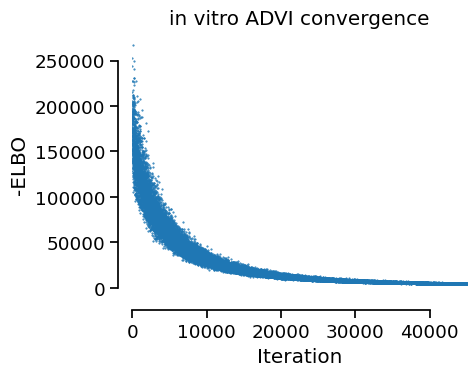

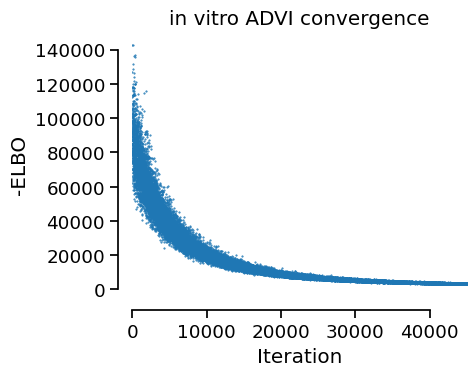

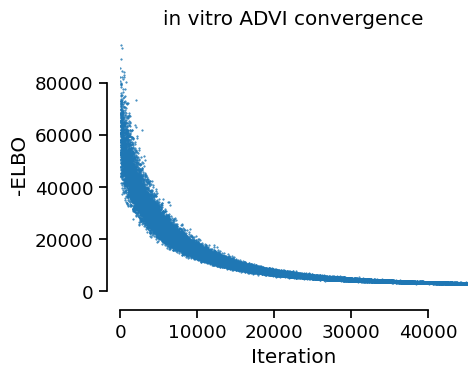

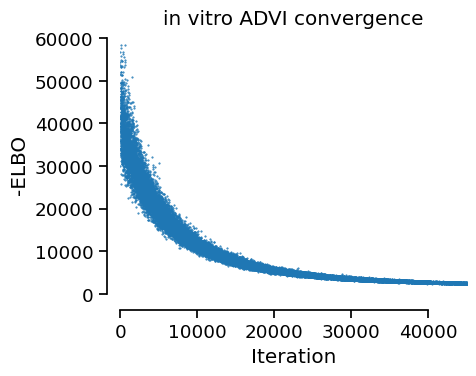

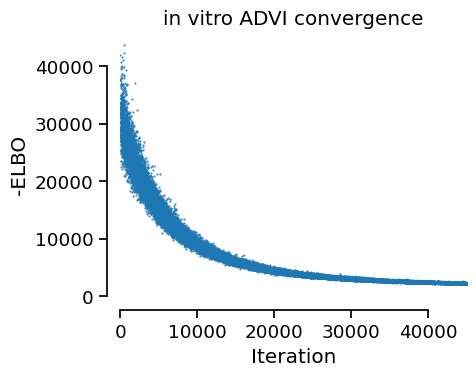

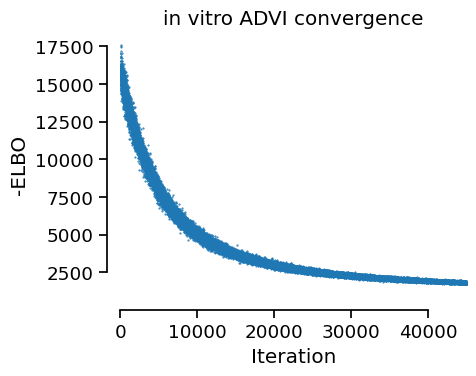

In [6]:
trace01 = run_ADVI(BMCA_obj01)
trace02 = run_ADVI(BMCA_obj02)
trace03 = run_ADVI(BMCA_obj03)
trace04 = run_ADVI(BMCA_obj04)
trace05 = run_ADVI(BMCA_obj05)
trace10 = run_ADVI(BMCA_obj10)


In [7]:
ExTrace_01 = (trace01['posterior']['Ex']).to_numpy().squeeze()
ExTrace_02 = (trace02['posterior']['Ex']).to_numpy().squeeze()
ExTrace_03 = (trace03['posterior']['Ex']).to_numpy().squeeze()
ExTrace_04 = (trace04['posterior']['Ex']).to_numpy().squeeze()
ExTrace_05 = (trace05['posterior']['Ex']).to_numpy().squeeze()
ExTrace_10 = (trace10['posterior']['Ex']).to_numpy().squeeze()


In [8]:
medEx_01 = np.median(ExTrace_01, axis=0)
medEx_02 = np.median(ExTrace_02, axis=0)
medEx_03 = np.median(ExTrace_03, axis=0)
medEx_04 = np.median(ExTrace_04, axis=0)
medEx_05 = np.median(ExTrace_05, axis=0)
medEx_10 = np.median(ExTrace_10, axis=0)


In [9]:
# first regulator, H on v5
a = [pd.DataFrame(r.getScaledElasticityMatrix(), columns=r.getFloatingSpeciesIds(), index=r.getReactionIds()).loc['v5']]
for i in [medEx_01, medEx_02, medEx_03, medEx_04, medEx_05, medEx_10]:
    aa = pd.DataFrame(i, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds()).loc['v5']
    a.append(aa)
a = pd.concat(a, axis=1)
a.set_axis(['gt', '0.1x','0.2x','0.3x','0.4x','0.5x', '1.01x'], axis='columns') 

,gt,0.1x,0.2x,0.3x,0.4x,0.5x,1.01x
D,-0.639183,-0.639241,-0.565129,-0.583355,-0.631660,-0.657878,-1.038628
B,0.000000,-0.016216,0.005589,0.003288,0.000598,0.004508,0.003409
O,0.000000,0.007185,-0.004437,0.000427,-0.008300,0.003657,0.003639
F,0.000000,0.000353,0.002114,-0.003942,-0.008894,0.001163,-0.001505
H,-0.179893,-0.039035,-0.024404,-0.016286,-0.005747,-0.010230,0.003223
M,0.000000,-0.008726,-0.005354,0.000610,0.005880,0.011689,-0.005038
E,0.000000,0.004509,-0.000522,0.000386,0.004107,-0.000156,0.006165
R,0.000000,-0.005250,0.003295,0.000821,0.006002,0.001344,0.007943
I,0.000000,-0.018946,-0.018898,-0.011125,-0.008688,-0.006160,-0.002669
C,0.879317,0.806795,0.742108,0.764459,0.790996,0.819542,0.900957


In [10]:
# second regulator, O on v15
a = [pd.DataFrame(r.getScaledElasticityMatrix(), columns=r.getFloatingSpeciesIds(), index=r.getReactionIds()).loc['v15']]
for i in [medEx_01, medEx_02, medEx_03, medEx_04, medEx_05, medEx_10]:
    aa = pd.DataFrame(i, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds()).loc['v15']
    a.append(aa)
a = pd.concat(a, axis=1)
a.set_axis(['gt', '0.1x','0.2x','0.3x','0.4x','0.5x', '1.01x'], axis='columns') 

,gt,0.1x,0.2x,0.3x,0.4x,0.5x,1.01x
D,0.000000,-0.004294,0.005188,-0.007173,-0.005216,0.002475,0.003661
B,0.000000,-0.012119,-0.022785,-0.018686,-0.015159,-0.010146,0.007269
O,-0.064708,-0.006129,-0.000081,0.001679,-0.006249,-0.013049,0.011016
F,0.714601,0.472367,0.535467,0.592301,0.625518,0.663533,0.895440
H,0.000000,-0.007877,0.000953,-0.012875,-0.004412,-0.003546,-0.007728
M,0.000000,-0.008454,0.009546,-0.001547,0.008306,-0.002109,-0.007059
E,0.000000,-0.028765,0.004564,0.001629,0.004029,-0.003015,-0.001043
R,0.000000,-0.005939,-0.011024,-0.008739,-0.006872,-0.008089,-0.000914
I,0.000000,-0.006332,0.006600,0.000828,0.001920,0.002176,0.001781
C,0.000000,0.015937,-0.005410,-0.007186,-0.008229,-0.005943,-0.000341


## Calculating FCCs

In [11]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [12]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(1000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(1000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    # return CCC.eval(), FCC
    return FCC


### Negative predictions

In [13]:
postFCC01 = estimate_CCs(BMCA_obj01, ExTrace_01)
postFCC02 = estimate_CCs(BMCA_obj02, ExTrace_02)
postFCC03 = estimate_CCs(BMCA_obj03, ExTrace_03)
postFCC04 = estimate_CCs(BMCA_obj04, ExTrace_04)
postFCC05 = estimate_CCs(BMCA_obj05, ExTrace_05)
postFCC10 = estimate_CCs(BMCA_obj10, ExTrace_10)


In [14]:
rxn_FCCs = [postFCC01,postFCC02,postFCC03,postFCC04,postFCC05, postFCC10]
pt_labels = ['0.1x','0.2x','0.3x','0.4x','0.5x', '1.01x']

In [15]:
def append_FCC_df(postFCC, label):
    dfs=[]
    
    for idx, rxn in enumerate(r.getReactionIds()):
        # negativity applied here
        df = -pd.DataFrame(postFCC[:,idx,:], columns=r.getReactionIds())
        df['pt_rxn']=[rxn]*len(df)
        dfs.append(df)
    
    w = pd.concat(dfs)
    w['pt_str']=[label]*len(w)
    return w

prd_FCCs = pd.concat([append_FCC_df(rxn_FCCs[i], pt_labels[i]) for i in range(len(rxn_FCCs))])

In [16]:
medPrdFCCs = pd.pivot_table(prd_FCCs, index=['pt_rxn','pt_str'], aggfunc='median', sort=False)
# medPrdFCCs.loc['vGLK']
medPrdFCCs.head()

,,v2,v3,v13,v4,v5,v6,v7,v8,v9,v10,v11,v12,v14,v15,v16,v17,v18,v19,v21
pt_rxn,pt_str,,,,,,,,,,,,,,,,,,,
v2,0.1x,-1.436417,0.008610,0.092573,0.145453,0.041710,0.014092,0.063709,0.005446,0.029258,0.004841,0.007496,0.016225,-0.000536,-0.015341,0.000280,0.002831,0.009771,0.009300,-0.002549
v3,0.1x,0.979435,-1.935788,0.706207,-0.194366,-0.049454,-0.028427,-0.250796,0.011897,-0.087994,-0.017231,-0.024898,-0.090247,-0.014585,-0.026816,0.000325,0.004498,0.006067,0.014743,-0.004040
v13,0.1x,0.979435,0.064212,-1.293793,-0.194366,-0.049454,-0.028427,-0.250796,0.011897,-0.087994,-0.017231,-0.024898,-0.090247,-0.014585,-0.026816,0.000325,0.004498,0.006067,0.014743,-0.004040
v4,0.1x,0.435559,-0.008604,-0.092628,-1.754198,0.068645,0.026271,0.166871,0.003314,0.060935,0.011323,0.016652,0.049295,0.003972,-0.006598,-0.000262,0.001865,0.005424,0.005340,-0.001463
v5,0.1x,0.435559,-0.008604,-0.092628,0.245802,-1.931355,0.026271,0.166871,0.003314,0.060935,0.011323,0.016652,0.049295,0.003972,-0.006598,-0.000262,0.001865,0.005424,0.005340,-0.001463


### Graphing the averaged differences between ground truth and predicted distributions

C:\Users\user\AppData\Local\Temp\ipykernel_19372\3859003407.py:12: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



<Figure size 1600x1000 with 0 Axes>

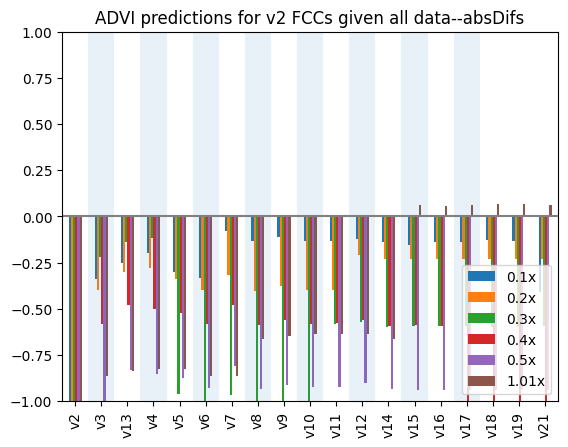

<Figure size 1600x1000 with 0 Axes>

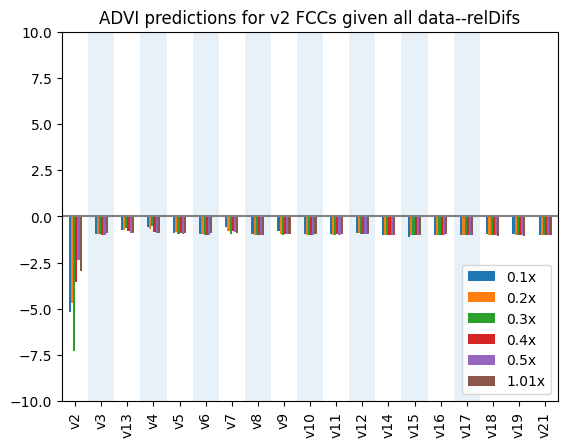

<Figure size 1600x1000 with 0 Axes>

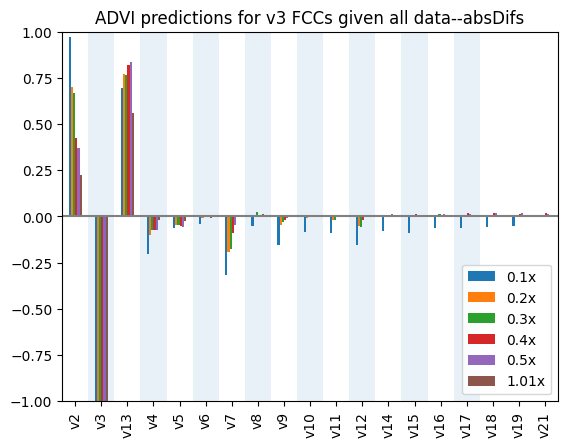

<Figure size 1600x1000 with 0 Axes>

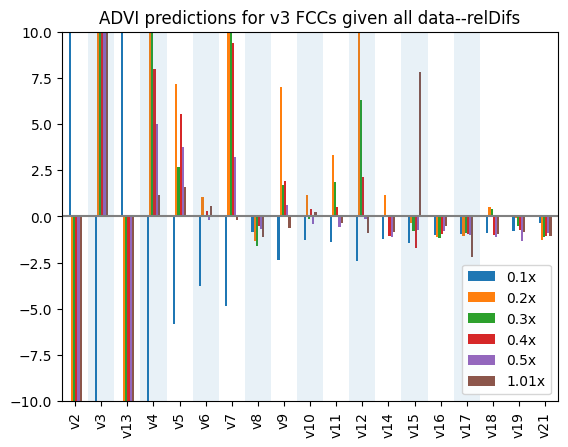

<Figure size 1600x1000 with 0 Axes>

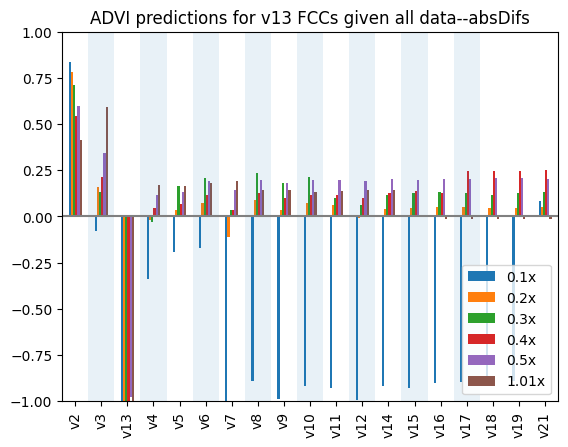

<Figure size 1600x1000 with 0 Axes>

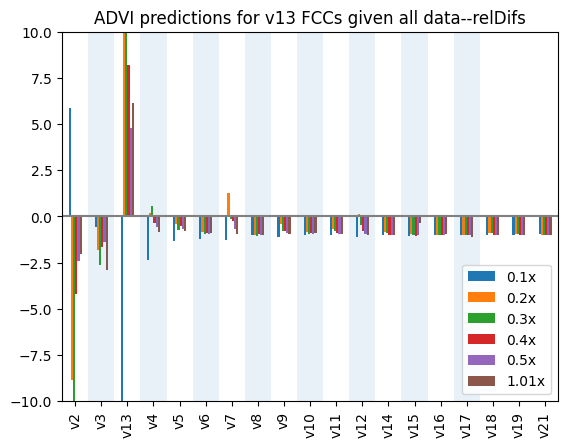

<Figure size 1600x1000 with 0 Axes>

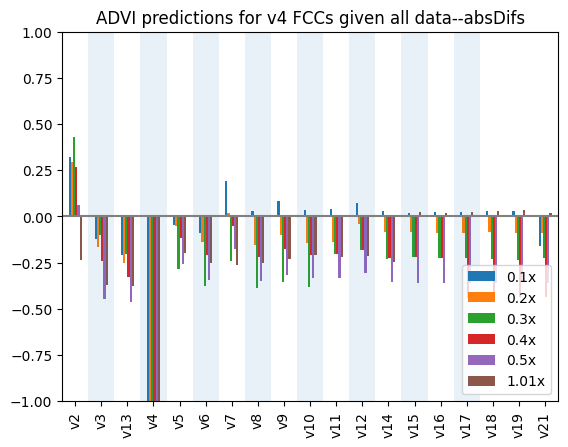

<Figure size 1600x1000 with 0 Axes>

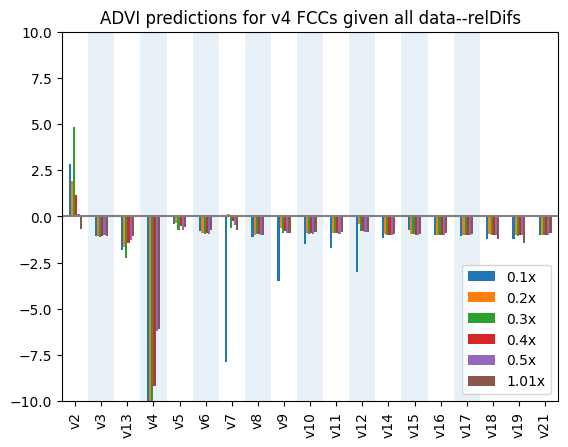

<Figure size 1600x1000 with 0 Axes>

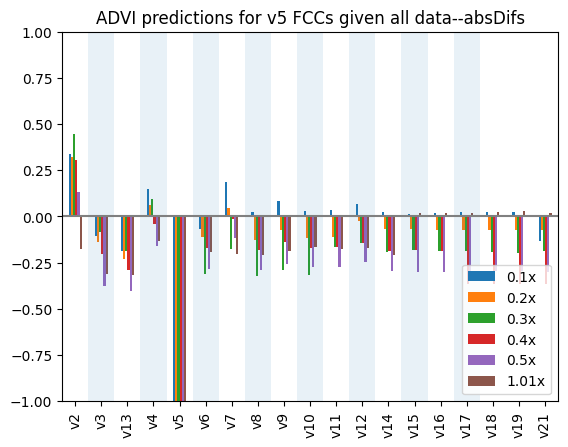

<Figure size 1600x1000 with 0 Axes>

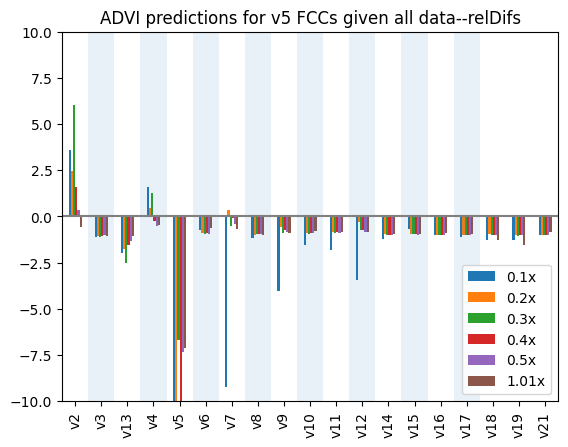

<Figure size 1600x1000 with 0 Axes>

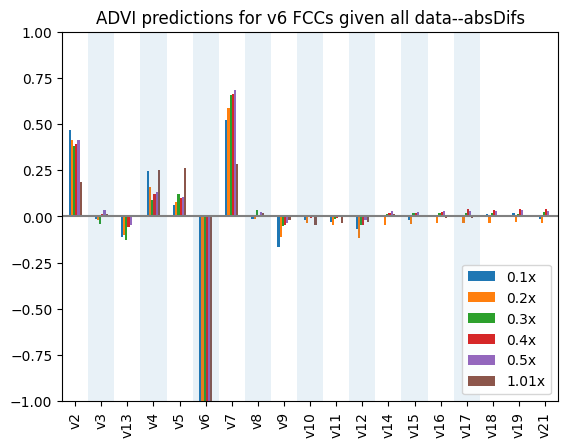

<Figure size 1600x1000 with 0 Axes>

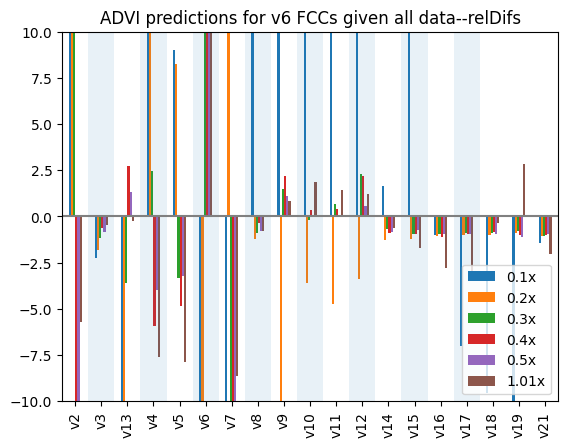

<Figure size 1600x1000 with 0 Axes>

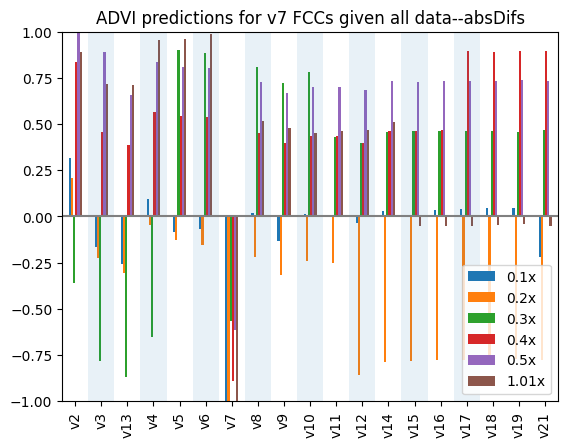

<Figure size 1600x1000 with 0 Axes>

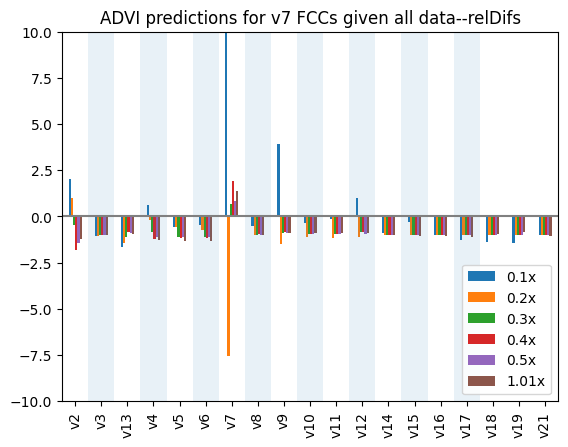

<Figure size 1600x1000 with 0 Axes>

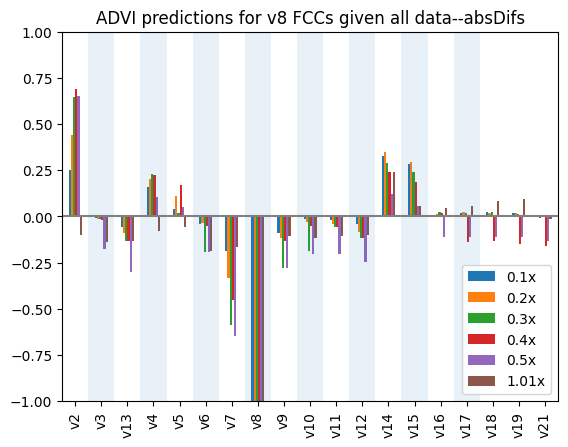

<Figure size 1600x1000 with 0 Axes>

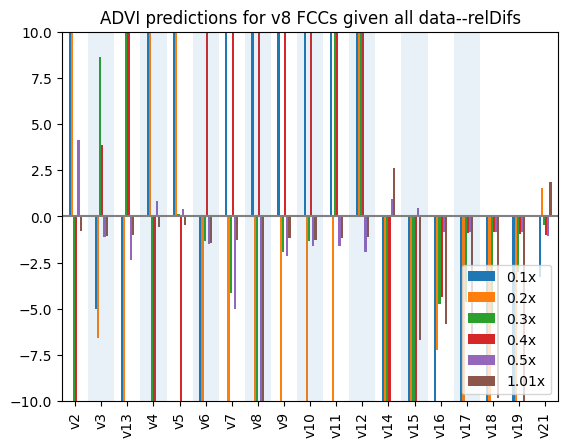

<Figure size 1600x1000 with 0 Axes>

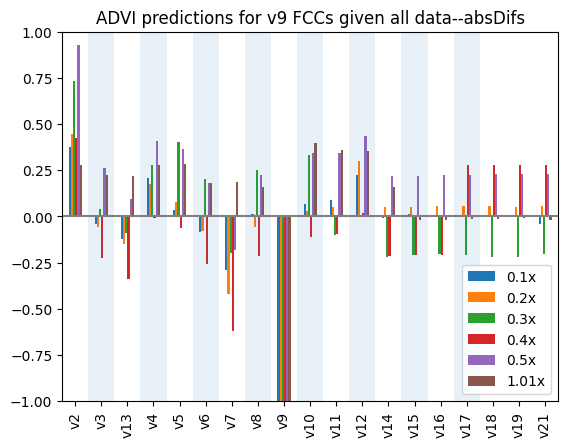

<Figure size 1600x1000 with 0 Axes>

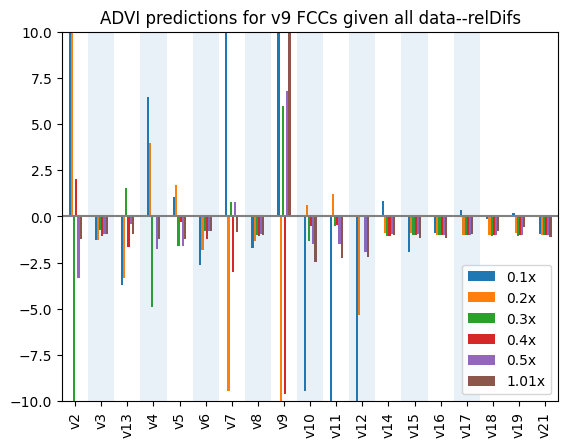

<Figure size 1600x1000 with 0 Axes>

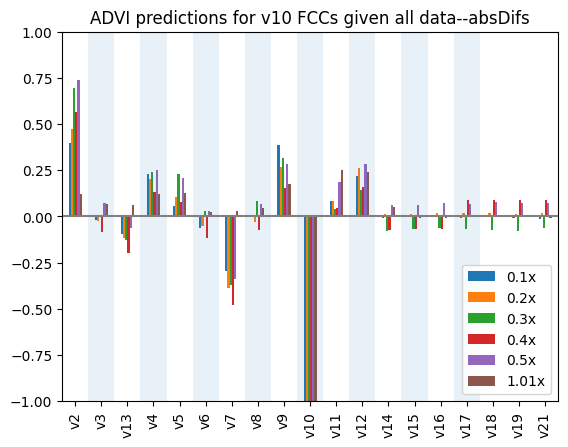

<Figure size 1600x1000 with 0 Axes>

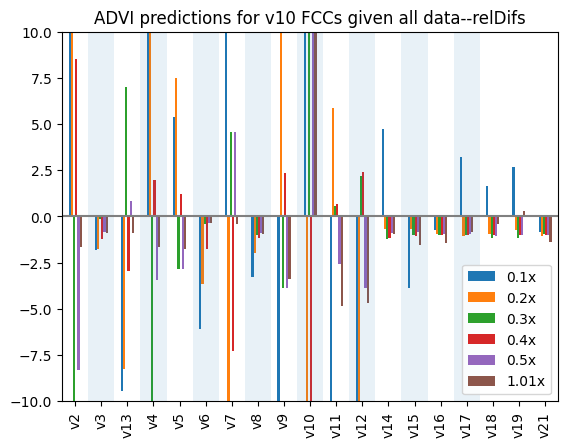

<Figure size 1600x1000 with 0 Axes>

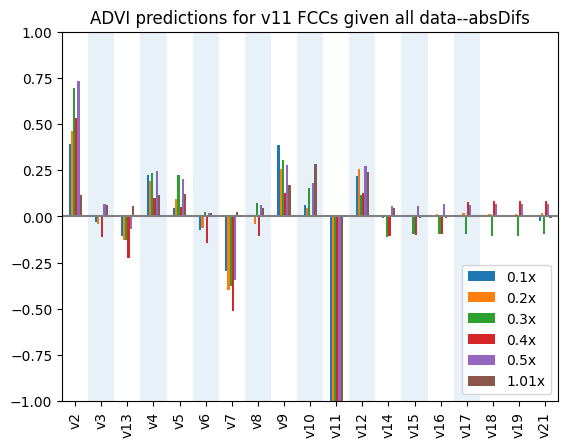

<Figure size 1600x1000 with 0 Axes>

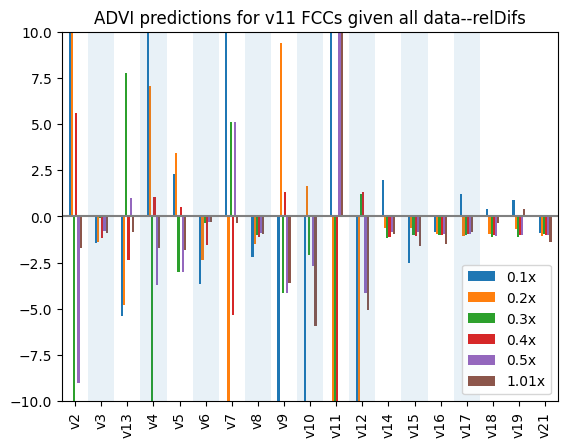

<Figure size 1600x1000 with 0 Axes>

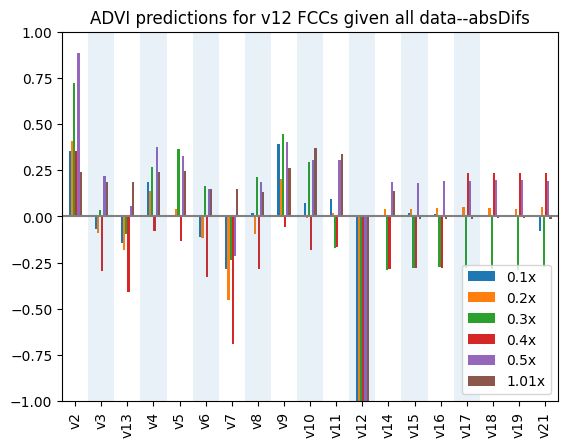

<Figure size 1600x1000 with 0 Axes>

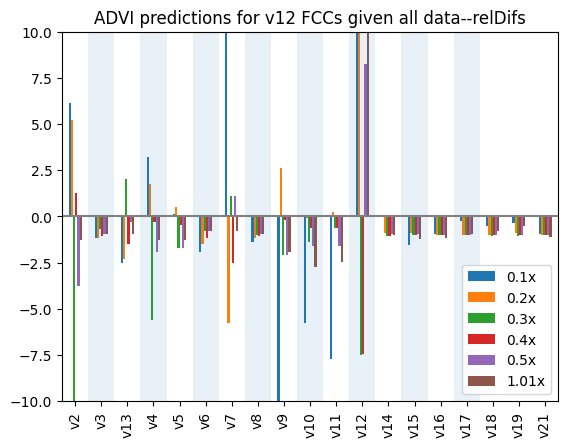

<Figure size 1600x1000 with 0 Axes>

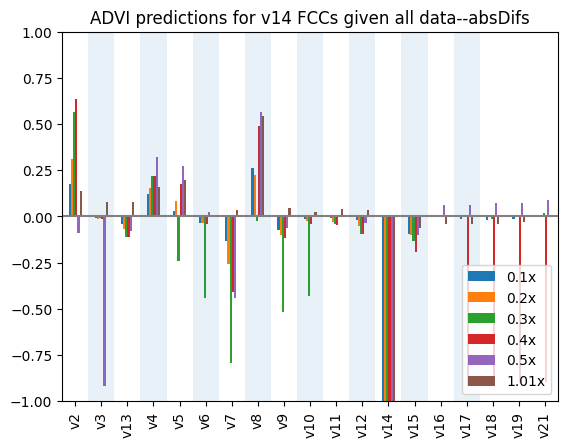

<Figure size 1600x1000 with 0 Axes>

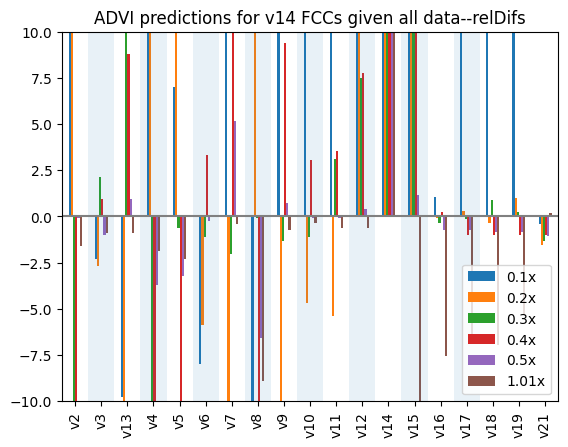

<Figure size 1600x1000 with 0 Axes>

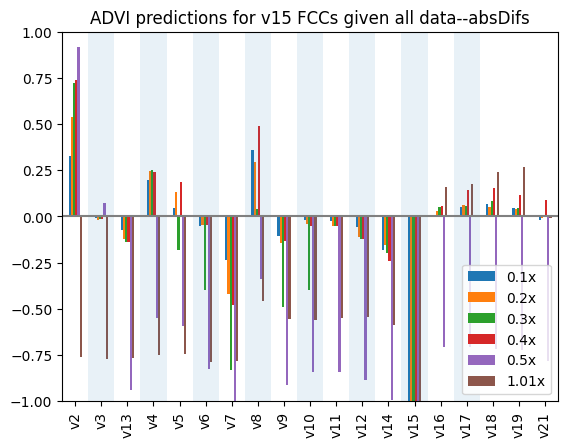

<Figure size 1600x1000 with 0 Axes>

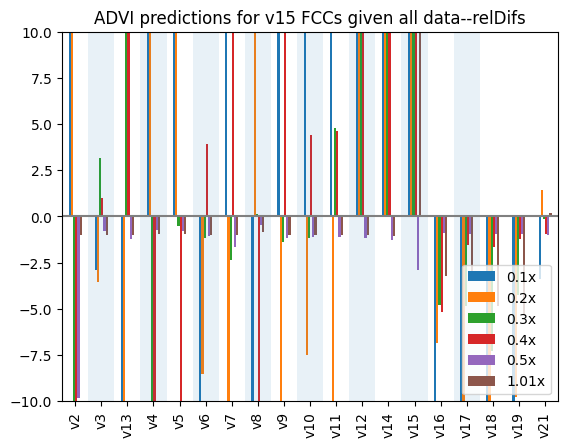

<Figure size 1600x1000 with 0 Axes>

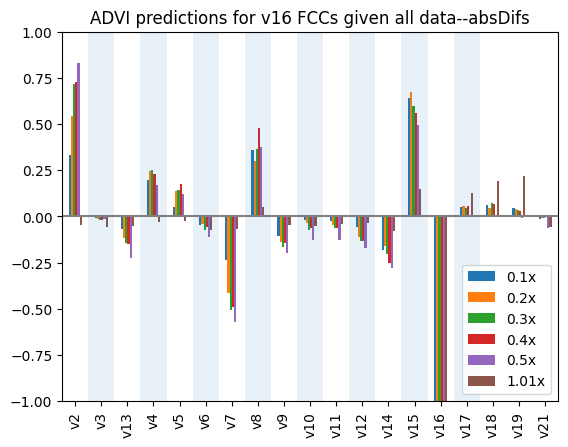

<Figure size 1600x1000 with 0 Axes>

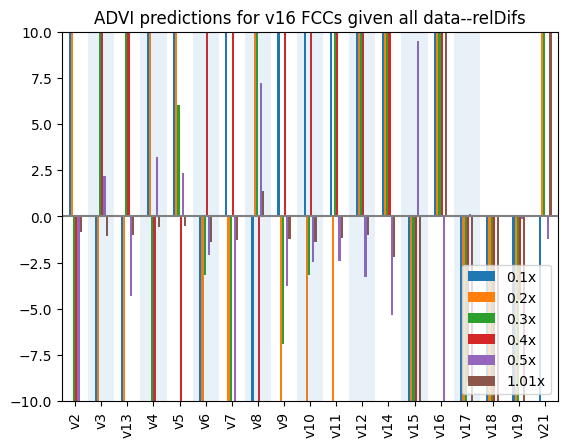

<Figure size 1600x1000 with 0 Axes>

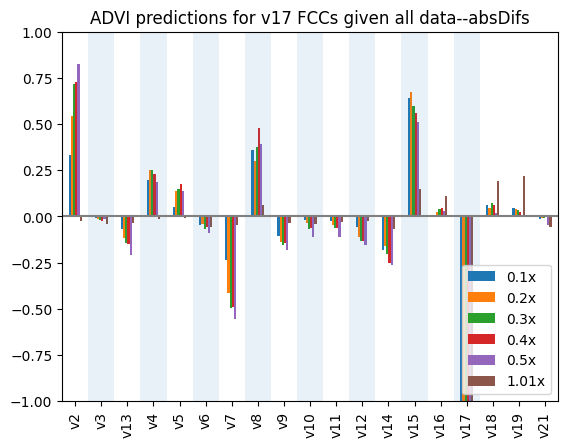

<Figure size 1600x1000 with 0 Axes>

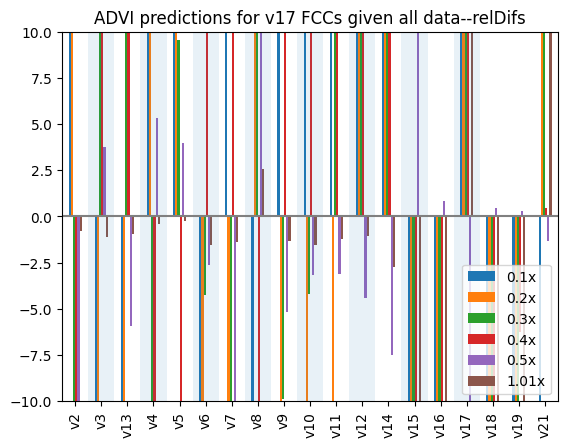

<Figure size 1600x1000 with 0 Axes>

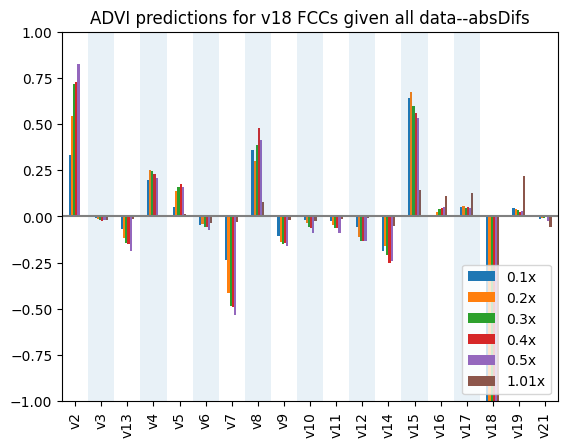

<Figure size 1600x1000 with 0 Axes>

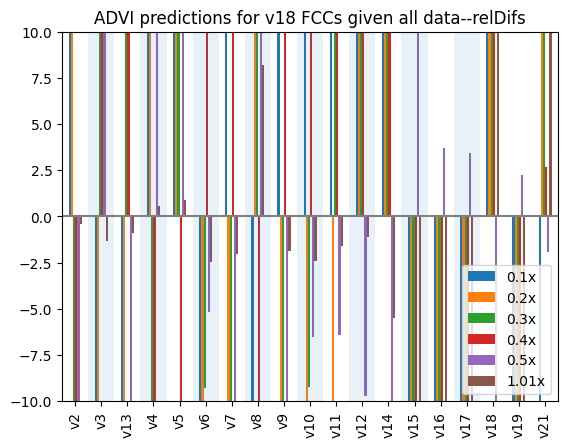

<Figure size 1600x1000 with 0 Axes>

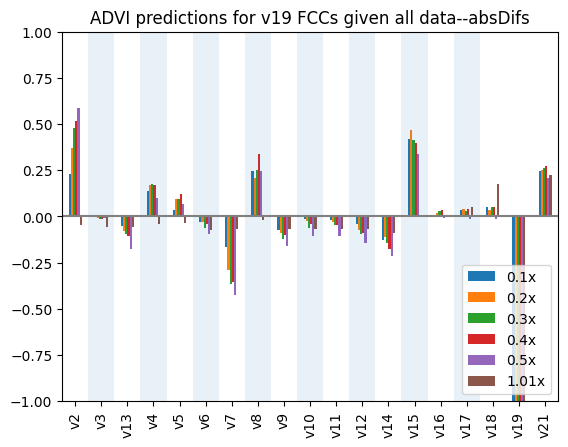

<Figure size 1600x1000 with 0 Axes>

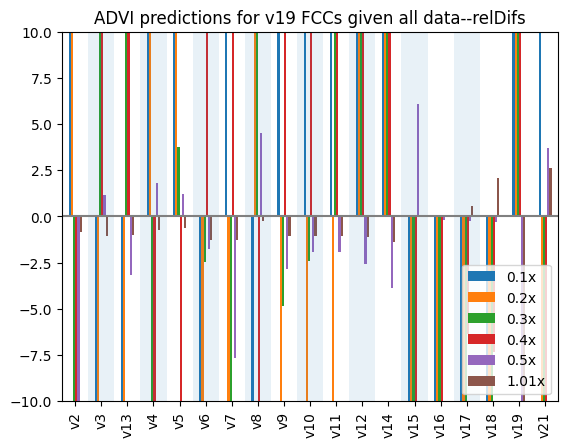

<Figure size 1600x1000 with 0 Axes>

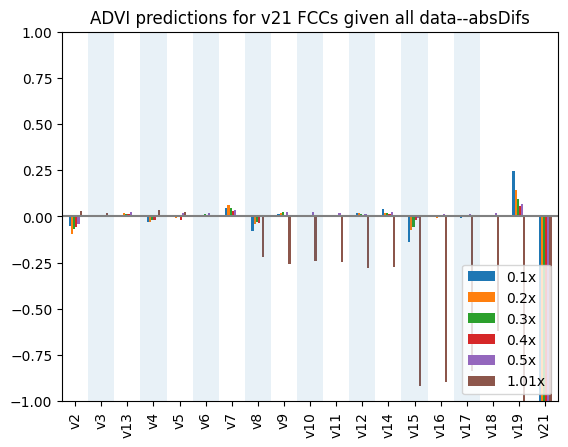

<Figure size 1600x1000 with 0 Axes>

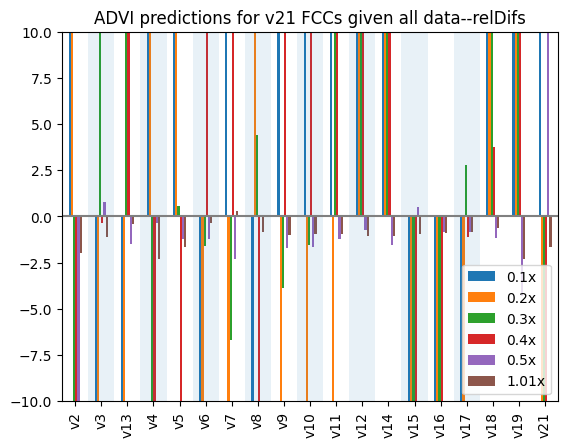

In [17]:
# for each reaction that can be perturbed
for rxn in r.getReactionIds():
    # locate the applicable rows in the medPrdFCCs df
    a = medPrdFCCs.loc[rxn]
    gtvals = np.repeat(gtFCC[rxn].values, repeats=len(pt_labels), axis=0).reshape((len(pt_labels), -1))
    # calculate the absolute difference...
    absDifs = a - gtvals
    # and the relative difference
    relDifs = absDifs/gtvals
    
    # plot both graphs 
    f1 = plt.figure(figsize=(16, 10))
    absDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-1,1))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--absDifs')

    f2 = plt.figure(figsize=(16, 10))
    relDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-10,10))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--relDifs')

In [18]:
plt.close("all")

## Evaluating FCC ranking

In [19]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')
# gtFCC_rankings

In [20]:
m1 = gtFCC_rankings.isin([1.0])  
m2 = gtFCC_rankings.isin([2.0])  
m3 = gtFCC_rankings.isin([3.0])  
a = m1.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
b = m2.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
c = m3.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)

trueRanks = pd.concat([a,b,c], axis=1)
trueRanks['topThree'] = trueRanks[0] + trueRanks[1] + trueRanks[2]

In [21]:
rxn_FCCs = [postFCC01,postFCC02,postFCC03,postFCC04,postFCC05, postFCC10]
scores = []
for pt_level in rxn_FCCs:
    postFCC_med=pd.DataFrame(np.median(pt_level, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
    # m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
    postFCC_med = pd.DataFrame(np.select([m1], [float('Nan')], postFCC_med), columns=gtFCC.columns, index=gtFCC.index)
    postFCC_med_rankings= postFCC_med.rank(axis=1, ascending=False, na_option='keep')
  
    m1 = postFCC_med_rankings.isin([1.0])  
    m2 = postFCC_med_rankings.isin([2.0])  
    m3 = postFCC_med_rankings.isin([3.0])  
    a = m1.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
    b = m2.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
    c = m3.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)

    prdRanks = pd.concat([a,b,c], axis=1)
    prdRanks['topThree'] = prdRanks[0] + prdRanks[1] + prdRanks[2]

    scores.append([len([i for i in prdRanks['topThree'][rxn] if i in trueRanks['topThree'][rxn]]) for rxn in r.getReactionIds()])

topThreeCheckdf = pd.DataFrame(scores, columns=r.getReactionIds(), index=pt_labels).T

In [22]:
topThreeCheckdf.style.background_gradient(cmap='RdYlBu', axis=None)
# sns.heatmap(topThreeCheckdf, annot=True, cmap='RdYlBu')

,0.1x,0.2x,0.3x,0.4x,0.5x,1.01x
v2,2,3,1,3,2,2
v3,2,3,2,3,1,2
v13,1,2,2,3,1,2
v4,1,3,2,3,2,2
v5,2,3,2,3,2,2
v6,2,3,2,3,2,2
v7,1,2,1,3,1,2
v8,0,2,1,2,1,0
v9,1,3,1,3,2,1
v10,1,2,1,3,1,1


In [23]:
topThreeCheckdf.sum(axis=0)

0.1x     22
0.2x     49
0.3x     29
0.4x     52
0.5x     29
1.01x    21
dtype: int64